In [1]:
%load_ext autoreload
%autoreload 2

# Make sure the project root is in Python path
import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.table import Table
import matplotlib as mpl
from scipy.ndimage import shift
from src.analysis import gaussian_weight, wiener_deconvolution
from scipy.spatial import cKDTree
import pandas as pd
from scipy.signal import fftconvolve
from multiprocessing.dummy import Pool
from tqdm import tqdm

In [4]:
# Set plot parameters
mpl.rcParams['image.cmap'] = 'grey'
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['axes.edgecolor'] = 'none'
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['ytick.labelleft'] = False
mpl.rcParams['axes.grid'] = False

In [11]:
location = '/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData'

In [ ]:
# Open a compressed FITS file directly
with fits.open(f"{location}/53.0_-28.0/z_53.00_-28.00.fits") as hdul:
    hdul.info()          # Display HDU (Header/Data Unit) info
    data = hdul[0].data  # Access the image or table data
    header = hdul[0].header  # Access the header metadata
    hdul.close()

print(header)

Filename: /net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/53.0_-28.0/z_53.00_-28.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  IMAGE         1 ImageHDU        35   (3400, 3400)   float32   
  2  MASK          1 ImageHDU        52   (3400, 3400)   int32   
  3  VARIANCE      1 ImageHDU        35   (3400, 3400)   float32   
  4  ARCHIVE_INDEX    1 BinTableHDU     41   30922R x 7C   [1J, 1J, 1J, 1J, 1J, 64A, 64A]   
  5  FilterLabel    1 BinTableHDU     28   1R x 3C   [2X, 32A, 32A]   
  6  SkyWcs        1 BinTableHDU     17   588R x 1C   [1QB(15561)]   
  7  CoaddInputs    1 BinTableHDU     81   153R x 16C   [1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1K, 1J, 1J, 1J, 1J, 1J, 1D, 32A]   
  8  PhotoCalib    1 BinTableHDU     36   587R x 5C   [1X, 1D, 1D, 1J, 1J]   
  9  ChebyshevBoundedField    1 BinTableHDU     41   14671R x 6C   [1J, 1J, 1J, 1J, 1J, 1D]   
 10  CoaddInputs    2 BinTableHDU     90   433R x 18C   [1J, 1

Filename: /net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/53.0_-28.0/z_53.00_-28.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  IMAGE         1 ImageHDU        35   (3400, 3400)   float32   
  2  MASK          1 ImageHDU        52   (3400, 3400)   int32   
  3  VARIANCE      1 ImageHDU        35   (3400, 3400)   float32   
  4  ARCHIVE_INDEX    1 BinTableHDU     41   30922R x 7C   [1J, 1J, 1J, 1J, 1J, 64A, 64A]   
  5  FilterLabel    1 BinTableHDU     28   1R x 3C   [2X, 32A, 32A]   
  6  SkyWcs        1 BinTableHDU     17   588R x 1C   [1QB(15561)]   
  7  CoaddInputs    1 BinTableHDU     81   153R x 16C   [1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1K, 1J, 1J, 1J, 1J, 1J, 1D, 32A]   
  8  PhotoCalib    1 BinTableHDU     36   587R x 5C   [1X, 1D, 1D, 1J, 1J]   
  9  ChebyshevBoundedField    1 BinTableHDU     41   14671R x 6C   [1J, 1J, 1J, 1J, 1J, 1D]   
 10  CoaddInputs    2 BinTableHDU     90   433R x 18C   [1J, 1

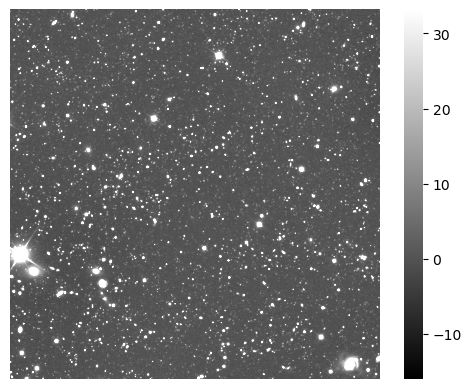

In [ ]:
# Open the FITS file
with fits.open(f'{location}/53.0_-28.0/z_53.00_-28.00.fits') as hdul:
    hdul.info()  # Lists HDUs (Header/Data Units) in the file
    header = hdul[0].header

    for key, value in header.items():
        print(f"{key:10} : {value}")
    # Usually the image data is in the first HDU
    image_data = hdul[1].data

zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(image_data)
norm = ImageNormalize(vmin=vmin, vmax=vmax)

# Simple plot
plt.imshow(image_data, norm=norm)
plt.colorbar()
plt.show()

In [12]:
# Read .cat file (ignores lines starting with #)
catalog = Table.read(f'{location}/53.0_-28.0/z.cat', format='ascii')

# Show first few rows
print(catalog[:5])

 X_IMAGE  Y_IMAGE  FLUX_AUTO FLUXERR_AUTO ... B_IMAGE THETA_IMAGE NUMBER FLAGS
   pix      pix        ct         ct      ...   pix       deg                 
--------- -------- --------- ------------ ... ------- ----------- ------ -----
2375.0886 268.0146  57010.91     185.5348 ...   4.987       46.13      1     3
3388.8828 187.6023  434927.5     201.9361 ...    6.05       67.93      2    26
3124.8557 130.6079 1728749.0     632.0483 ...  17.862       30.98      3    18
 247.9779  98.8473 1695438.0      116.696 ...   3.675       76.41      4     4
3291.7043  83.7808  581763.5     105.3381 ...   3.362       45.09      5     0


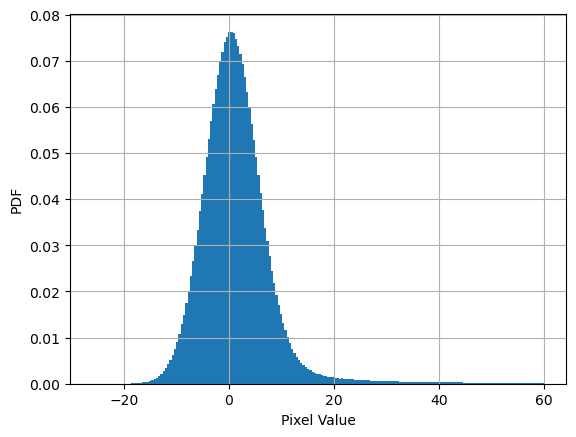

In [13]:
with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    plt.hist(image_data[image_data<60].flatten(), bins=200, density=True)
    plt.xlabel('Pixel Value')
    plt.ylabel('PDF')
    plt.show()

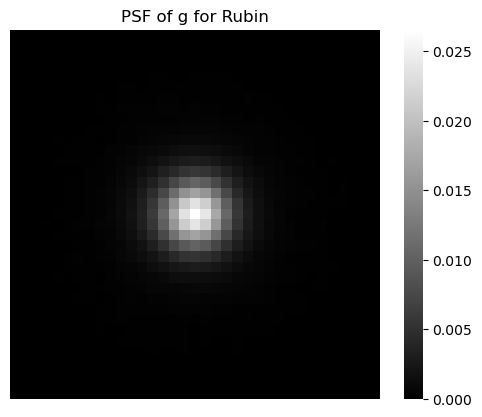

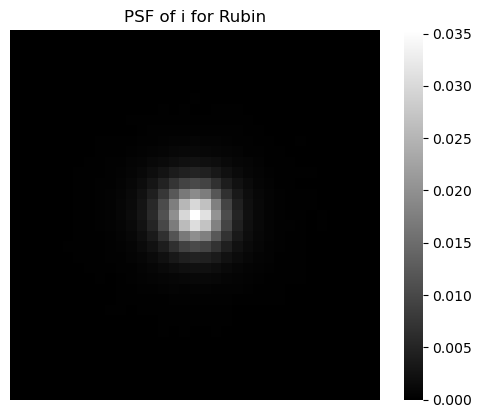

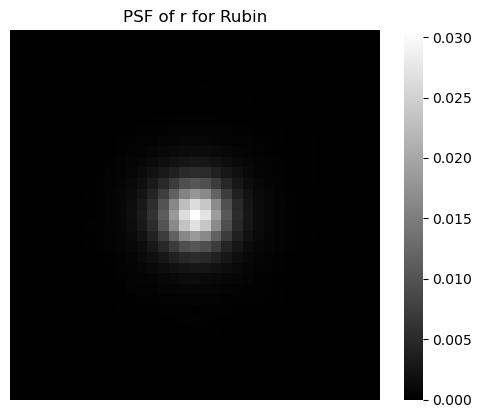

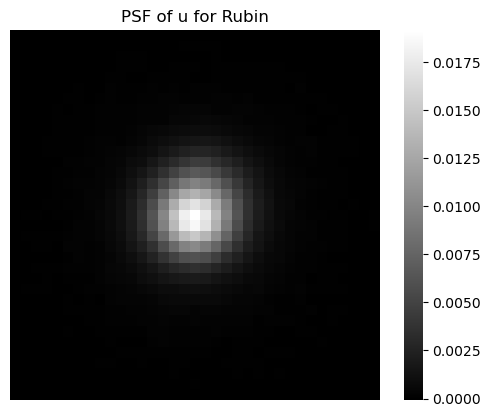

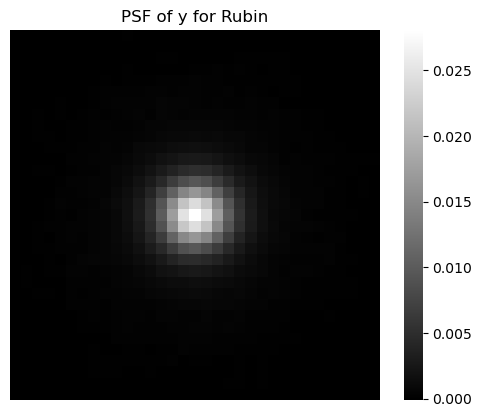

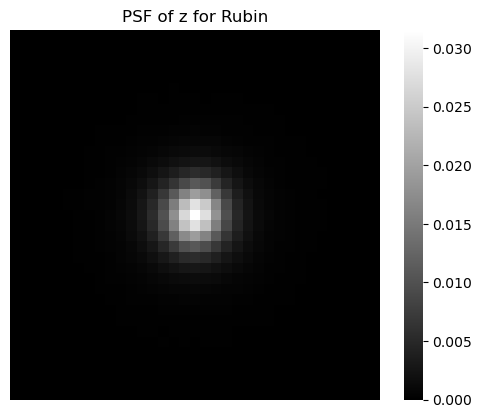

In [16]:
filters = ['g', 'i', 'r', 'u', 'y', 'z']
for fil in filters:
    # Open the FITS file
    with fits.open(f'{location}/53.0_-28.0/{fil}_53.00_-28.00.psf.fits') as hdul:
        psf = hdul[0].data

        # Close the FITS file
        hdul.close()

    # Simple plot
    plt.title(f'PSF of {fil} for Rubin')
    plt.imshow(psf)
    plt.colorbar()
    plt.show()
